# Quantifying Crowded Trades(QCT): A Comprehensive Analysis
### sector_centrality
### Collins Emezie Ugwuozor, Jayesh Chandra Gupta, Emmanuel Effiong Asuquo

In [1]:
#Import the neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_datareader import data
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

In [2]:
# Pick up table of S&P 500 listed companies from Wikipedia.
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

In [3]:
table = data[0]
table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
table['GICS Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Consumer Staples', 'Utilities', 'Financials',
       'Consumer Discretionary', 'Materials', 'Real Estate',
       'Communication Services', 'Energy'], dtype=object)

In [5]:
# Select sectors of S&P 500
industrials_sector = table[table['GICS Sector'] == 'Industrials'] # XLI
health_sector = table[table['GICS Sector'] == 'Health Care'] # XLV
tech_sector = table[table['GICS Sector'] == 'Information Technology'] # XLK
consumer_staples_sector = table[table['GICS Sector'] == 'Consumer Staples'] # XLP
utilities_sector = table[table['GICS Sector'] == 'Utilities'] # XLU
financial_sector = table[table['GICS Sector'] == 'Financials'] # XLF
consumer_discretionary_sector = table[table['GICS Sector'] == 'Consumer Discretionary'] # XLY
materials_sector = table[table['GICS Sector'] == 'Materials'] # XLB
real_estate_sector = table[table['GICS Sector'] == 'Real Estate'] # XLRE
communication_services_sector = table[table['GICS Sector'] == 'Communication Services'] # XLC *XTL
energy_sector = table[table['GICS Sector'] == 'Energy'] # XLE

In [6]:
# Define dates for five year historical prices
start_date = "2018-01-01"
end_date = "2023-01-01"

In [7]:
# Sector ETFs for centrality across sectors
symbols = ['XLB', 'XLI', 'XLY', 'XLP', 'XLE', 'XLV', 'XLF', 'XLK', 'XTL', 'XLU', 'XLRE']

In [8]:
# Get the  "Adj Close" data from Yahoo Finance
df_sectors = yf.download(symbols, start=start_date, end=end_date)['Adj Close']
# Calculate daily returns and drop NaNs
df_sectors = df_sectors.pct_change()
df_sectors.dropna(inplace=True)

# Standardize the data and calculate covariance matrix
scaler = StandardScaler()
df_sectors_scaled = scaler.fit_transform(df_sectors)
df_sector_cov = np.cov(df_sectors_scaled.T)

df_sectors.head(10)

[*********************100%%**********************]  11 of 11 completed


,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY,XTL
Date,,,,,,,,,,,
2018-01-03,0.007004,0.014976,0.005373,0.005386,0.008341,-0.000354,0.000305,-0.007856,0.009568,0.004591,0.000723
2018-01-04,0.008735,0.006036,0.009262,0.007318,0.005055,0.002831,-0.017094,-0.008304,0.001422,0.003279,0.005777
2018-01-05,0.008018,-0.000400,0.002824,0.006875,0.010517,0.004411,0.002174,-0.000389,0.008517,0.007923,0.002154
2018-01-08,0.001432,0.006002,-0.001408,0.004123,0.003771,0.002459,0.006817,0.009351,-0.003636,0.001179,0.009313
2018-01-09,-0.001589,-0.002519,0.007755,0.006415,-0.002555,-0.001402,-0.011388,-0.009843,0.011773,0.001963,-0.006956
2018-01-10,-0.006046,-0.001196,0.008395,-0.000127,-0.003465,-0.004913,-0.015567,-0.010916,-0.001745,-0.000686,-0.012581
2018-01-11,0.013126,0.020495,0.004856,0.012750,0.004081,-0.001411,-0.006325,-0.003745,0.004313,0.016270,0.013899
2018-01-12,0.001580,0.009650,0.008975,0.009316,0.005872,0.000353,-0.007320,-0.005737,0.007660,0.012923,0.009425
2018-01-16,-0.011674,-0.012658,-0.002737,-0.008981,-0.003891,0.004590,0.004809,-0.002189,0.004953,-0.007141,-0.011176


#### Step 1: Calculate Asset Centrality

## Absorbtion Ratio $$AR = \frac{\sum_{i=1}^n \sigma^2E_i}{\sum_{j=1}^N \sigma^2A_j}$$

- $N$ = number of sectors
- $n$ = number of eigenvectors
- $\sigma^2E_i$ = variance of the $i^{th}$ eigenvector
- $\sigma^2A_j$ = variance of the $j^{th}$ sector

The fraction of the total variance that is "absorbed"/explained by a fixed number of eigenvectors

We will Calculate the Absorbsion Ratio(AR) for Assets and Sectors using:
- PCA
- Eigen decomposition of Covariance matrix
- Eigen values and sum of variance of original data

The absorption ratio:
- Measures the degree of concentration within a set of assets.
- Represents the portion of variability in asset returns that can be attributed to a specific number of factors in a Principal Component Analysis (PCA).
- When elevated, indicates a propensity for shocks to rapidly disseminate across a wide spectrum.

In [9]:
# AR calculation using PCA
n = 2
sectors_pca = PCA(n_components=n)
sectors_pca.fit(df_sectors_scaled)
ar_pca = np.sum(sectors_pca.explained_variance_ratio_)
print(f'The percent of explained variance in the first {n} principal components = {ar_pca}')

# AR calculation using eigen decompostion of covariance matrix
w, v = np.linalg.eig(df_sector_cov)
sorted_eigenvalues = w.argsort()[::-1]
var_ratio = [eig/np.sum(w) for eig in w[sorted_eigenvalues]]
print(f'The percent of explained variance in the first {n} eigen vectors = {np.sum(var_ratio[0:2])}')

# AR calculation using eigen values and sum of variances of original data
ar_num = np.sum(w[sorted_eigenvalues][0:n])
ar_denom = np.sum(np.var(df_sectors_scaled, axis=0))
ar = ar_num/ar_denom
print(f'The absorbtion ratio of the first {n} eigen vectors over original X variance = {ar}')

The percent of explained variance in the first 2 principal components = 0.8072519053381569
The percent of explained variance in the first 2 eigen vectors = 0.8072519053381579
The absorbtion ratio of the first 2 eigen vectors over original X variance = 0.8078941105134468


## Centrality  $$C_i = \frac {\sum_{j=1}^n \biggl( AR^j  \frac{| EV_i^j |}{\sum_{k=1}^N | EV_k^j |} \biggr)}{\sum_{j=1}^n AR^j} $$

- $C_i$ = sector's centrality score
- $AR^j$ = absorbtion ratio of the $j^th$ eigenvector
- $EV_i^j$ = absolute value of the exposure of the $i^th$ sector within the $j^th$ eigenvector
- $n$ = number of eigenvectors in the numerator of the absorbtion ratio
- $N$ = total number of sectors

In [10]:
def centrality_score(X, n=2):
    N = X.shape[1]
    pca_model = PCA(n_components=n)
    pca_model.fit(X)
    EV = pca_model.components_
    AR = pca_model.explained_variance_ratio_
    C_list = []
    for i in range(N):
        C_num = []
        C_denom = []
        for j in range(n):
            C_num.append(AR[j] * \
                    (abs(EV[j][i])/\
                     sum([abs(EV[j][k]) for k in range(N)])))
            C_denom.append(AR[j])

        C_list.append(sum(C_num)/sum(C_denom))
    return C_list

To assess sector centrality, we will follow these steps:
- Gather five years of historical daily returns for individual sectors.
- Assign weights to each historical return based on the square root of their respective market capitalization weights.
- Calculate the covariance matrix encompassing the sectors.
- Determine sector centrality using the top two eigenvectors.


In [11]:
# Getting quote data from yahoo finance
tickers= symbols
market_cap=[]
for ticker in tickers:
    print(ticker)
    try:
        market_cap.append(data.get_quote_yahoo(ticker)['marketCap'])
    except:
        print('Yahoo Finace quote error with: ', ticker)

XLB
Yahoo Finace quote error with:  XLB
XLI
Yahoo Finace quote error with:  XLI
XLY
Yahoo Finace quote error with:  XLY
XLP
Yahoo Finace quote error with:  XLP
XLE
Yahoo Finace quote error with:  XLE
XLV
Yahoo Finace quote error with:  XLV
XLF
Yahoo Finace quote error with:  XLF
XLK
Yahoo Finace quote error with:  XLK
XTL
Yahoo Finace quote error with:  XTL
XLU
Yahoo Finace quote error with:  XLU
XLRE
Yahoo Finace quote error with:  XLRE


In [12]:
# Sector's Mkt Cap (USD m) picked manually From bloomberg
market_cap = [5150,37211,29320,14101,52475,15373,4368,13622,35850,16512,48]

In [13]:
weights=[]
for i in range(11):
    weights.append(market_cap[i]/(np.array(market_cap)).sum())
weights

[0.022987992679551844,
 0.1660982904075347,
 0.13087532919698255,
 0.06294246306298264,
 0.23423202249698702,
 0.068620274070437,
 0.019497388742579117,
 0.060804356559389365,
 0.1600232111770745,
 0.07370441458733205,
 0.0002142570191492211]

In [14]:
# multiply the returns by the square root of market weights of each sector
weights = np.array([.023,.166,.131,.063,.234,.069, .019,.061,.160,.074,.0002])
sector_weights = dict(zip(df_sectors.columns, weights*100))
weighted_df = df_sectors.copy()
for sector in df_sectors.columns:
    weighted_df.loc[:,sector] = weighted_df.loc[:, sector] * sector_weights[sector]**.5
weighted_df.head()

,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY,XTL
Date,,,,,,,,,,,
2018-01-03,0.010622,0.061018,0.019446,0.013519,0.040348,-0.000929,0.000421,-0.019403,0.038273,0.012490,0.000102
2018-01-04,0.013248,0.024594,0.033524,0.018367,0.024454,0.007436,-0.023562,-0.020510,0.005687,0.008919,0.000817
2018-01-05,0.012159,-0.001630,0.010221,0.017256,0.050874,0.011586,0.002997,-0.000961,0.034069,0.021552,0.000305
2018-01-08,0.002171,0.024455,-0.005096,0.010348,0.018241,0.006459,0.009397,0.023095,-0.014544,0.003207,0.001317
2018-01-09,-0.002409,-0.010265,0.028067,0.016102,-0.012358,-0.003682,-0.015697,-0.024311,0.047091,0.005339,-0.000984


In [15]:
print(f'Not scaled - {sorted(zip(symbols,[np.around(C,3) for C in centrality_score(df_sectors)]), key=lambda x: x[1], reverse=True)}')

unscaled_scores = dict(zip(symbols, [np.around(C,3) for C in centrality_score(df_sectors)]))

Not scaled - [('XLI', 0.15), ('XLE', 0.107), ('XLY', 0.099), ('XLU', 0.094), ('XLP', 0.088), ('XLB', 0.087), ('XLF', 0.086), ('XLRE', 0.086), ('XLK', 0.071), ('XTL', 0.071), ('XLV', 0.061)]


In [16]:
print(f'Scaled - {sorted(zip(symbols,[np.around(C,3) for C in centrality_score(df_sectors_scaled)]), key=lambda x: x[1], reverse=True)}')

scaled_scores = dict(zip(symbols, [np.around(C,3) for C in centrality_score(df_sectors_scaled)]))

Scaled - [('XLP', 0.095), ('XLB', 0.094), ('XLV', 0.094), ('XLY', 0.093), ('XLF', 0.093), ('XLK', 0.092), ('XLU', 0.09), ('XLRE', 0.09), ('XTL', 0.089), ('XLE', 0.087), ('XLI', 0.083)]


In [17]:
print(f'Weighted - {sorted(zip(symbols,[np.around(C,3) for C in centrality_score(weighted_df)]), key=lambda x: x[1], reverse=True)}')

weighted_scores = dict(zip(symbols, [np.around(C,3) for C in centrality_score(weighted_df)]))

Weighted - [('XLI', 0.225), ('XLE', 0.2), ('XLY', 0.118), ('XTL', 0.101), ('XLU', 0.093), ('XLP', 0.072), ('XLV', 0.053), ('XLK', 0.053), ('XLB', 0.043), ('XLF', 0.037), ('XLRE', 0.004)]


In [18]:
# Create a dataframe of scores computed from different methods
for sector in unscaled_scores:
    unscaled_scores[sector] = [unscaled_scores[sector], scaled_scores[sector], weighted_scores[sector]]
scores_df = pd.DataFrame(data=unscaled_scores, index=['Unscaled', 'Scaled', 'Weighted'])
scores_df

,XLB,XLI,XLY,XLP,XLE,XLV,XLF,XLK,XTL,XLU,XLRE
Unscaled,0.087,0.150,0.099,0.088,0.107,0.061,0.086,0.071,0.071,0.094,0.086
Scaled,0.094,0.083,0.093,0.095,0.087,0.094,0.093,0.092,0.089,0.090,0.090
Weighted,0.043,0.225,0.118,0.072,0.200,0.053,0.037,0.053,0.101,0.093,0.004


In [19]:
# rolling 1-year centrality score
rolling_Cs = [centrality_score(weighted_df.iloc[i-252:i,:]) for i in range(252, weighted_df.shape[0]+1)]

<Axes: title={'center': 'Sector EFT 1-year Rolling Centrality Score'}>

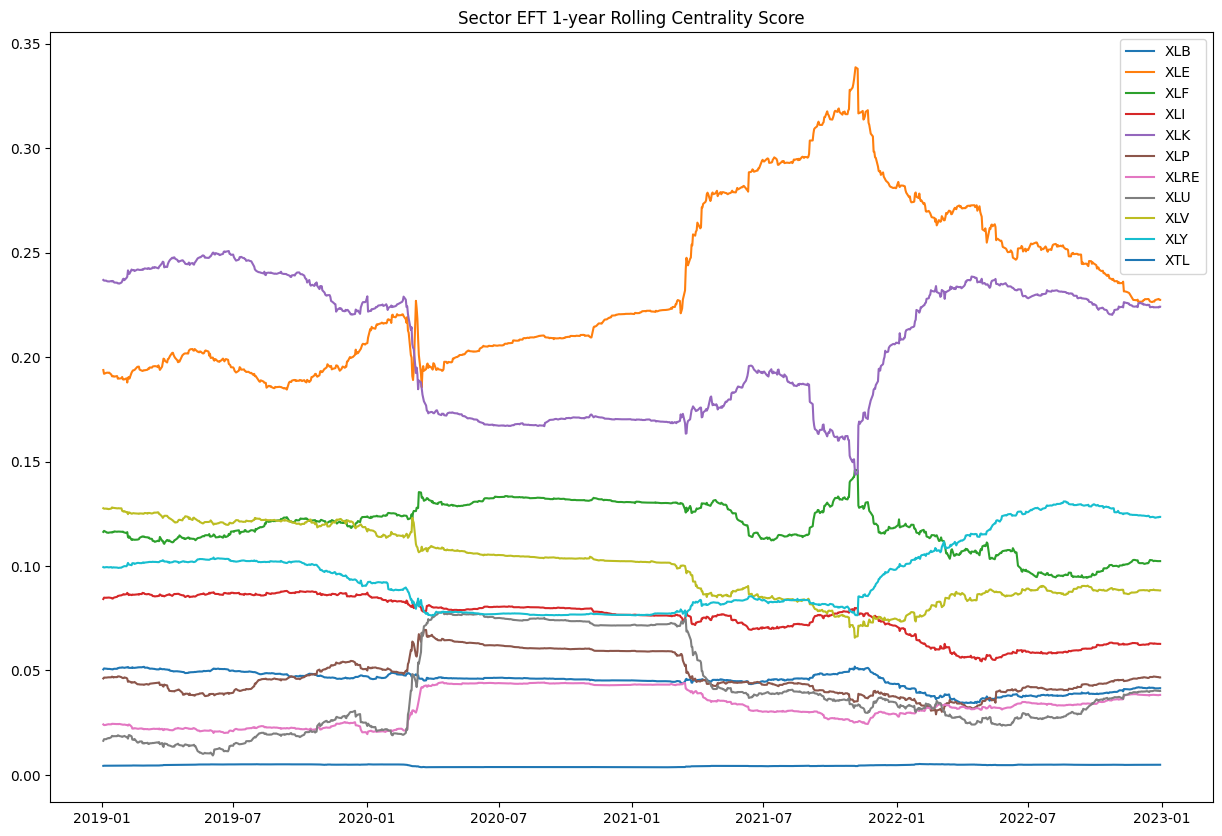

In [20]:
pd.DataFrame(data=rolling_Cs, columns=df_sectors.columns, index=[date.date() for date in df_sectors.index[251:]]).plot(figsize=(15,10), title='Sector EFT 1-year Rolling Centrality Score')